# Imports

In [1]:
import torch
import math
from PIL import Image
import matplotlib.pyplot as plt
from sam3.model_builder import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor
# ref: https://huggingface.co/facebook/sam3

In [2]:
# Load SAM3 model
# I downloaded manually the model from hugging face repo: https://huggingface.co/facebook/sam3
# To access model weights you have to submit a request on the sam3 hugging face page
checkpoint_path = "Files/sam3.pt"

# Prompatble visual segmentation - images

In [3]:
model = build_sam3_image_model(checkpoint_path=checkpoint_path)
processor = Sam3Processor(model)

In [4]:
# here you should put your image
image = Image.open("test_image.jpeg")

In [5]:
image.size

(1201, 1600)

In [6]:
# to run the model faster
image = image.reduce(4)

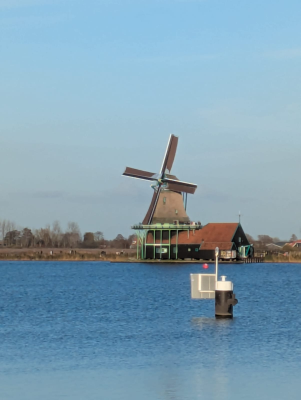

In [7]:
image

In [8]:
# prepare state (image on which we want to do predictions)
inference_state = processor.set_image(image)

In [9]:
# Prompt the model with text
text_prompt = "a windmill"
output = processor.set_text_prompt(state=inference_state, prompt=text_prompt)


In [10]:
# Get the masks, bounding boxes, and scores
masks, boxes, scores = output["masks"], output["boxes"], output["scores"]

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions for visualization
def to_numpy(x):
    if torch.is_tensor(x):
        x = x.detach().cpu()
        if x.ndim == 3 and x.shape[0] == 1:        # Fix for (1, H, W)
            x = x.squeeze(0)
        return x.numpy()
    x = np.array(x)
    if x.ndim == 3 and x.shape[0] == 1:
        x = x.squeeze(0)
    return x

def show_results(image, masks, boxes, scores, text_prompt, cols=3):
    # Convert image
    image_np = to_numpy(image)
    if image_np.ndim == 3 and image_np.shape[0] in (1, 3):  # CHW → HWC
        image_np = np.moveaxis(image_np, 0, -1)

    # Convert masks and boxes
    masks_np = [to_numpy(m) for m in masks]
    boxes_np = [to_numpy(b) for b in boxes]
    scores_np = [float(s) for s in scores]

    # Total panels: 1 original + N results
    n_items = 1 + len(masks_np)

    # Grid size
    rows = math.ceil(n_items / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = np.array(axes).reshape(rows, cols)

    # --- 1) Original image ---
    axes[0, 0].imshow(image_np)
    axes[0, 0].set_title("Original")
    axes[0, 0].axis("off")

    # --- 2) Results in grid ---
    index = 1
    for mask, box, score in zip(masks_np, boxes_np, scores_np):
        r = index // cols
        c = index % cols

        ax = axes[r, c]
        ax.imshow(image_np)
        ax.imshow(mask, alpha=0.6, cmap="viridis")

        # Bounding box
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             fill=False, color="red", linewidth=2)
        ax.add_patch(rect)

        ax.set_title(f"Score: {score:.3f}")
        ax.axis("off")

        index += 1

    # Turn off unused axes
    for i in range(index, rows * cols):
        r = i // cols
        c = i % cols
        axes[r, c].axis("off")

    plt.suptitle(f'Text Prompt: "{text_prompt}"', fontsize=18)
    plt.tight_layout()
    plt.show()


def show_results2(image, masks, boxes, scores, text_prompt):
    # Convert image to numpy
    image_np = to_numpy(image)
    if image_np.ndim == 3 and image_np.shape[0] in (1, 3):  # CHW → HWC
        image_np = np.moveaxis(image_np, 0, -1)

    masks_np = [to_numpy(m) for m in masks]

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # --- Left: Original image ---
    ax[0].imshow(image_np)
    ax[0].set_title("Original")
    ax[0].axis("off")

    # --- Right: Solid masks overlay ---
    ax[1].imshow(image_np)

    # Assign random distinct colors for each mask
    rng = np.random.default_rng(42)
    colors = rng.uniform(0, 1, size=(len(masks_np), 3))

    overlay = image_np.copy()

    for mask, color in zip(masks_np, colors):
        mask_bin = mask.astype(bool)

        # Apply solid color on masked region
        overlay[mask_bin] = (color * 255).astype(np.uint8)

    ax[1].imshow(overlay)
    ax[1].set_title("Detected Objects (Solid Mask)")
    ax[1].axis("off")

    plt.suptitle(f'Text Prompt: "{text_prompt}"', fontsize=16)
    plt.tight_layout()
    plt.show()

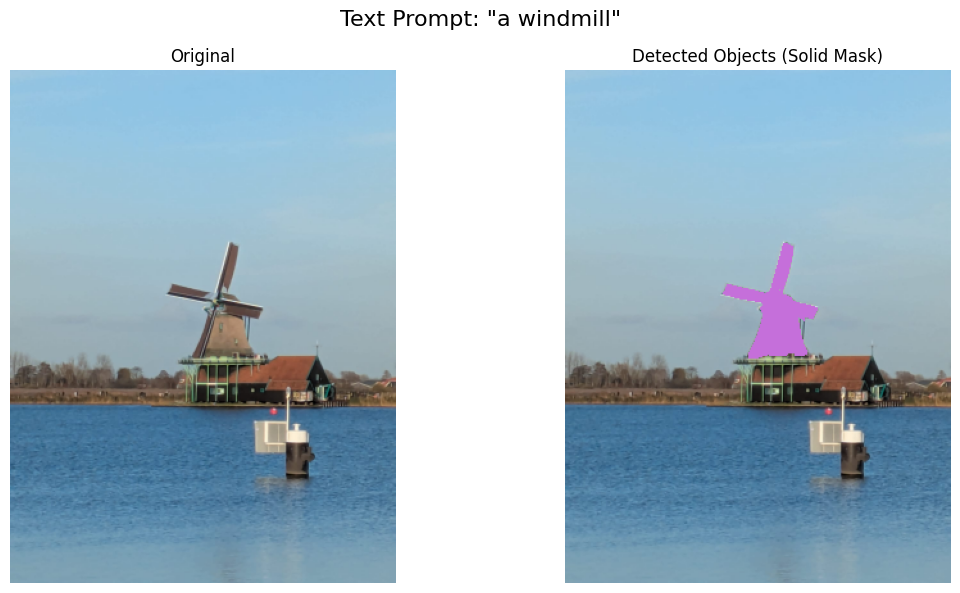

In [12]:
show_results2(image, masks, boxes, scores, text_prompt)

In [13]:
# clean up memory before using sam for video
del processor
del inference_state
del output
del model
import gc
gc.collect()

4960

In [14]:
import torch
torch.cuda.empty_cache()
torch.cuda.synchronize()


# Promptable Visual Segmentation - Video

In [15]:
from sam3.model_builder import build_sam3_video_predictor

video_predictor = build_sam3_video_predictor(checkpoint_path=checkpoint_path)

INFO 2025-12-08 11:06:05,961 1692 sam3_video_predictor.py: 299: using the following GPU IDs: [0]
INFO 2025-12-08 11:06:05,962 1692 sam3_video_predictor.py: 315: 


	*** START loading model on all ranks ***


INFO 2025-12-08 11:06:05,962 1692 sam3_video_predictor.py: 317: loading model on rank=0 with world_size=1 -- this could take a while ...
INFO 2025-12-08 11:06:10,775 1692 sam3_video_base.py: 124: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2025-12-08 11:06:14,432 1692 sam3_video_predictor.py: 319: loading model on rank=0 with world_size=1 -- DONE locally
INFO 2025-12-08 11:06:14,433 1692 sam3_video_predictor.py: 330: 


	*** DONE loading model on all ranks ***




In [16]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sam3.visualization_utils import (
    load_frame,
    prepare_masks_for_visualization,
    visualize_formatted_frame_output,
)

# font size for axes titles
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["figure.titlesize"] = 12


def propagate_in_video(predictor, session_id):
    # we will just propagate from frame 0 to the end of the video
    outputs_per_frame = {}
    for response in predictor.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id,
        )
    ):
        outputs_per_frame[response["frame_index"]] = response["outputs"]

    return outputs_per_frame


def abs_to_rel_coords(coords, IMG_WIDTH, IMG_HEIGHT, coord_type="point"):
    """Convert absolute coordinates to relative coordinates (0-1 range)

    Args:
        coords: List of coordinates
        coord_type: 'point' for [x, y] or 'box' for [x, y, w, h]
    """
    if coord_type == "point":
        return [[x / IMG_WIDTH, y / IMG_HEIGHT] for x, y in coords]
    elif coord_type == "box":
        return [
            [x / IMG_WIDTH, y / IMG_HEIGHT, w / IMG_WIDTH, h / IMG_HEIGHT]
            for x, y, w, h in coords
        ]
    else:
        raise ValueError(f"Unknown coord_type: {coord_type}")

In [17]:
# let's resize the video for faster inference
def resize_video_by_factor(input_path, output_path, scale_factor):
    # Open the video file
    cap = cv2.VideoCapture(input_path)

    if not cap.isOpened():
        print(f"Error: Could not open video file {input_path}")
        return

    # Get original video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Calculate new dimensions
    new_width = int(frame_width * scale_factor)
    new_height = int(frame_height * scale_factor)
    new_size = (new_width, new_height)

    # Define the codec and create VideoWriter object
    # For MP4 output, 'mp4v' or 'XVID' often works well. You may need to experiment.
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec for MP4
    out = cv2.VideoWriter(output_path, fourcc, fps, new_size)

    print(f"Original size: {frame_width}x{frame_height}")
    print(f"New size: {new_width}x{new_height}")

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Break the loop if reading frame fails (end of video)
        if not ret:
            break

        # Resize the frame
        # cv2.INTER_AREA is generally recommended for downscaling 
        resized_frame = cv2.resize(frame, new_size, interpolation=cv2.INTER_AREA)

        # Write the resized frame to the output file
        out.write(resized_frame)
        frame_count += 1
        
        # Optional: Display progress
        if frame_count % 100 == 0:
            print(f"Processed {frame_count} frames...", end='\r')

    # Release everything when the job is finished
    cap.release()
    out.release()
    print(f"\nFinished processing. Total frames: {frame_count}")
    print(f"Video saved to {output_path}")

In [18]:

# Adjust these paths for your environment
# put here your video
input_video = 'test-video.mp4' 
video_path = 'test-video-resized.mp4'
scale = 0.25  # Factor of 4 reduction (1/4)


resize_video_by_factor(input_video, video_path, scale)

Original size: 560x496
New size: 140x124
Processed 100 frames...
Finished processing. Total frames: 182
Video saved to test-video-resized.mp4


In [19]:
# load "video_frames_for_vis" for visualization purposes (they are not used by the model)
if isinstance(video_path, str) and video_path.endswith(".mp4"):
    cap = cv2.VideoCapture(video_path)
    video_frames_for_vis = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        video_frames_for_vis.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
else:
    video_frames_for_vis = glob.glob(os.path.join(video_path, "*.jpg"))
    try:
        # integer sort instead of string sort (so that e.g. "2.jpg" is before "11.jpg")
        video_frames_for_vis.sort(
            key=lambda p: int(os.path.splitext(os.path.basename(p))[0])
        )
    except ValueError:
        # fallback to lexicographic sort if the format is not "<frame_index>.jpg"
        print(
            f'frame names are not in "<frame_index>.jpg" format: {video_frames_for_vis[:5]=}, '
            f"falling back to lexicographic sort."
        )
        video_frames_for_vis.sort()

In [20]:
response = video_predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=video_path,
    )
)
session_id = response["session_id"]

frame loading (OpenCV) [rank=0]: 100%|██████████| 182/182 [00:00<00:00, 1276.23it/s]


In [21]:
# note: in case you already ran one text prompt and now want to switch to another text prompt
# it's required to reset the session first (otherwise the results would be wrong)
_ = video_predictor.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

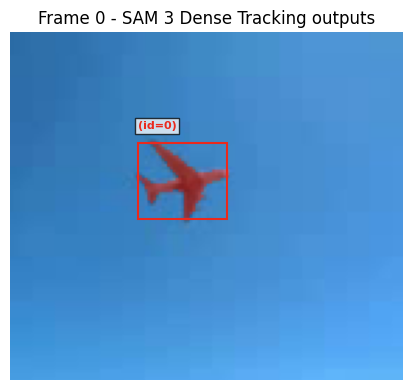

In [22]:
prompt_text_str = "a plane"
frame_idx = 0  # add a text prompt on frame 0
response = video_predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        text=prompt_text_str,
    )
)
out = response["outputs"]

plt.close("all")
visualize_formatted_frame_output(
    frame_idx,
    video_frames_for_vis,
    outputs_list=[prepare_masks_for_visualization({frame_idx: out})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
)

propagate_in_video:   0%|          | 0/182 [00:00<?, ?it/s]

propagate_in_video: 0it [00:00, ?it/s]

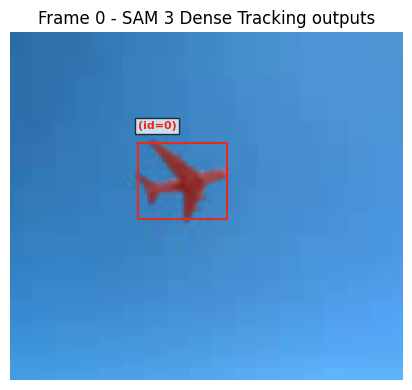

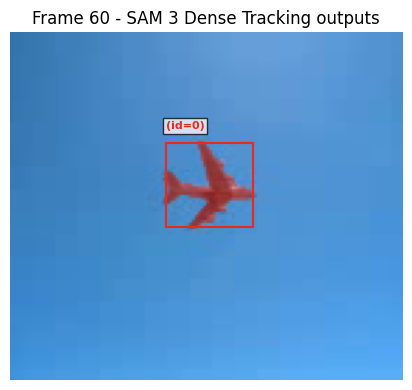

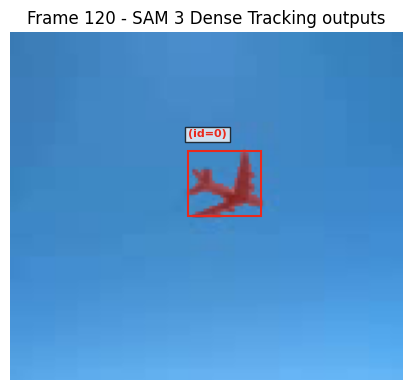

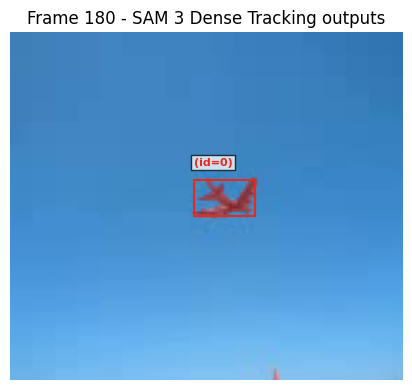

In [23]:
# now we propagate the outputs from frame 0 to the end of the video and collect all outputs
outputs_per_frame = propagate_in_video(video_predictor, session_id)

# finally, we reformat the outputs for visualization and plot the outputs every 60 frames
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)

vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    visualize_formatted_frame_output(
        frame_idx,
        video_frames_for_vis,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

In [24]:
import cv2
import numpy as np

# Simple color palette for objects
COLORS = [
    (0, 255, 0),    # green
    (0, 0, 255),    # red
    (255, 0, 0),    # blue
    (255, 255, 0),  # yellow
    (255, 0, 255),  # magenta
    (0, 255, 255),  # cyan
]

def show_detected_objects(frame, masks_dict):
    """
    Overlay detected objects (boolean masks) on a single video frame.

    Args:
        frame: HxWx3 uint8 RGB image
        masks_dict: {obj_id: mask}, mask is a 2D boolean array
    Returns:
        frame with overlay
    """
    vis_frame = frame.copy()
    h, w, _ = frame.shape
    
    for obj_id, mask in masks_dict.items():
        # Ensure mask is boolean and same size as frame
        if mask.shape != (h, w):
            mask_resized = cv2.resize(mask.astype(np.uint8), (w, h))
            mask_bin = mask_resized.astype(bool)
        else:
            mask_bin = mask

        color = COLORS[obj_id % len(COLORS)]

        # Overlay mask
        overlay = vis_frame.copy()
        overlay[mask_bin] = color
        alpha = 0.5
        vis_frame = cv2.addWeighted(overlay, alpha, vis_frame, 1 - alpha, 0)

        # Draw bounding box
        ys, xs = np.where(mask_bin)
        if len(xs) > 0 and len(ys) > 0:
            x1, x2 = xs.min(), xs.max()
            y1, y2 = ys.min(), ys.max()
            cv2.rectangle(vis_frame, (x1, y1), (x2, y2), color, 2)
            #cv2.putText(vis_frame, f"id={obj_id}", (x1, y1-5),
            #            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    return vis_frame


In [25]:
# saving the video
import cv2
import numpy as np

output_path = "segmented_video.mp4"
fps = 10

# Get frame dimensions from first frame
h, w, _ = video_frames_for_vis[0].shape
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

for frame_idx in range(len(video_frames_for_vis)):
    frame = video_frames_for_vis[frame_idx]
    masks_dict = outputs_per_frame[frame_idx]  # {obj_id: mask}
    
    # Generate visualization
    vis_frame = show_detected_objects(frame, masks_dict)
    
    # Convert RGB → BGR for OpenCV
    vis_frame_bgr = cv2.cvtColor(vis_frame, cv2.COLOR_RGB2BGR)
    
    # Write frame to video
    writer.write(vis_frame_bgr)

writer.release()
print(f"Video saved to: {output_path}")

Video saved to: segmented_video.mp4
